## Data Preparation

#### Install necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

#### Import CSV files

In [2]:
customers_df = pd.read_csv('dataset/olist_customers_dataset.csv')
geolocation_df = pd.read_csv('dataset/olist_geolocation_dataset.csv')
order_items_df = pd.read_csv('dataset/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('dataset/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('dataset/olist_orders_dataset.csv')
products_df = pd.read_csv('dataset/olist_products_dataset.csv')
sellers_df = pd.read_csv('dataset/olist_sellers_dataset.csv')
product_category_name_translation_df = pd.read_csv('dataset/product_category_name_translation.csv')

#### Create a list to facilitate data exploration:

In [3]:
dataset = [customers_df, geolocation_df, order_items_df, order_payments_df, order_reviews_df, orders_df, products_df, 
           sellers_df, product_category_name_translation_df]

#### Check if there are null values:

In [99]:
for df in dataset:
    print(df.isnull().sum())

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
order_id                            0
customer_id                         0
order_st

#### Conclusions:

- There are null values in reviews titles and messages, however, the review score is not empty, so it is still a valid data.

- Some orders miss approved and delivery dates, this should be cleaned up.

- There are empty values in products list, this should be cleaned up.

#### Remove null values:

In [5]:
products_df.dropna(inplace=True)
print(products_df.isnull().sum())

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


In [100]:
orders_df = orders_df[orders_df['order_delivered_customer_date'].notna()]
print(orders_df.isnull().sum())

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      1
order_delivered_customer_date     0
order_estimated_delivery_date     0
dtype: int64


#### Check for duplicate values:

In [7]:
for df in dataset:
    duplicates = df[df.duplicated()]
    if not duplicates.empty:
        print(df.info())
        print(duplicates)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
None
         geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
15                              1046       -23.546081       -46.644820   
44                              1046       -23.546081       -46.644820   
65                              1046       -23.546081       -46.644820   
66                              1009       -23.546935       -46.636588   
67                            

#### Conclusions:

- The duplicate values were found in geolocation dataframe. Let's remove them.

#### Remove duplicates from geolocation dataframe:

In [8]:
print(len(geolocation_df))
print(len(geolocation_df[geolocation_df.duplicated()]))

1000163
261831


In [9]:
geolocation_df.drop_duplicates(inplace=True)
print(len(geolocation_df))

738332


#### Change timestamp columns format to datetime:

In [101]:
order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])
order_reviews_df['review_creation_date'] = pd.to_datetime(order_reviews_df['review_creation_date'])

#### Create a database using SQLite:

In [102]:
conn = sqlite3.connect("olist_ecommerce.db")
cursor = conn.cursor()
cursor.execute("PRAGMA foreign_keys = ON;")

In [103]:
cursor.executescript("""
DROP TABLE IF EXISTS order_items;
DROP TABLE IF EXISTS order_reviews;
DROP TABLE IF EXISTS order_payments;
DROP TABLE IF EXISTS orders;
DROP TABLE IF EXISTS products;
DROP TABLE IF EXISTS sellers;
DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS geolocation;
DROP TABLE IF EXISTS product_category_name_translation;
""")

In [104]:
cursor.executescript("""
CREATE TABLE geolocation (
    geolocation_zip_code_prefix INTEGER,
    geolocation_lat REAL,
    geolocation_lng REAL,
    geolocation_city TEXT,
    geolocation_state TEXT
);

CREATE TABLE customers (
    customer_id TEXT PRIMARY KEY,
    customer_unique_id TEXT,
    customer_zip_code_prefix INTEGER,
    customer_city TEXT,
    customer_state TEXT
);

CREATE TABLE sellers (
    seller_id TEXT PRIMARY KEY,
    seller_zip_code_prefix INTEGER,
    seller_city TEXT,
    seller_state TEXT
);

CREATE TABLE product_category_name_translation (
    product_category_name TEXT PRIMARY KEY,
    product_category_name_english TEXT
);

CREATE TABLE products (
    product_id TEXT PRIMARY KEY,
    product_category_name TEXT,
    product_name_lenght REAL,
    product_description_lenght REAL,
    product_photos_qty REAL,
    product_weight_g REAL,
    product_length_cm REAL,
    product_height_cm REAL,
    product_width_cm REAL
);

CREATE TABLE orders (
    order_id TEXT PRIMARY KEY,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);

CREATE TABLE order_items (
    order_id TEXT,
    order_item_id INTEGER,
    product_id TEXT,
    seller_id TEXT,
    shipping_limit_date TEXT,
    price REAL,
    freight_value REAL,
    PRIMARY KEY (order_id, order_item_id)
);

CREATE TABLE order_reviews (
    review_id TEXT,
    order_id TEXT,
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TEXT,
    review_answer_timestamp TEXT,
    PRIMARY KEY (review_id, order_id)
);

CREATE TABLE order_payments (
    order_id TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL,
    PRIMARY KEY (order_id, payment_sequential)
);
""")

conn.commit()
conn.close()

#### Insert data into the tables:

In [105]:
conn = sqlite3.connect("olist_ecommerce.db")
cursor = conn.cursor()

geolocation_df.to_sql("geolocation", conn, if_exists="append", index=False)
customers_df.to_sql("customers", conn, if_exists="append", index=False)
order_items_df.to_sql("order_items", conn, if_exists="append", index=False)
order_payments_df.to_sql("order_payments", conn, if_exists="append", index=False)
order_reviews_df.to_sql("order_reviews", conn, if_exists="append", index=False)
orders_df.to_sql("orders", conn, if_exists="append", index=False)
sellers_df.to_sql("sellers", conn, if_exists="append", index=False)
products_df.to_sql("products", conn, if_exists="append", index=False)
product_category_name_translation_df.to_sql("product_category_name_translation", conn, if_exists="append", index=False)

conn.commit()
conn.close()

#### Make a test query to check the database:

In [106]:
conn = sqlite3.connect("olist_ecommerce.db")

query = """
SELECT o.order_id, c.customer_unique_id, oi.product_id, s.seller_id, p.product_category_name
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN sellers s ON oi.seller_id = s.seller_id
JOIN products p ON oi.product_id = p.product_id
LIMIT 5
"""
df_result = pd.read_sql(query, conn)
df_result.head(3)

,order_id,customer_unique_id,product_id,seller_id,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao


## Exploratory Data Analysis

### What is the volume of orders per month? Is there seasonality in sales?

In [107]:
query = """
    SELECT
    STRFTIME('%Y-%m', order_purchase_timestamp) AS month,
    COUNT(*) AS order_volume
FROM orders
GROUP BY month
ORDER BY month;
"""

orders_per_month = pd.read_sql(query, conn)
orders_per_month.head(3)

,month,order_volume
0,2016-09,1
1,2016-10,270
2,2016-12,1


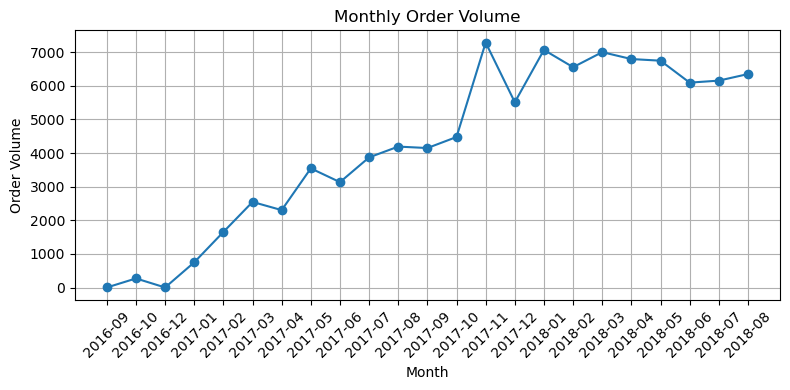

In [108]:
plt.figure(figsize=(8, 4))
plt.plot(orders_per_month['month'], orders_per_month['order_volume'], marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Order Volume')
plt.xlabel('Month')
plt.ylabel('Order Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Conclusion:

#### The data does not show significant seasonality in sales.

### What is the distribution of delivery times for orders?

In [109]:
query = """
    SELECT
    ROUND(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp)) AS delivery_days,
    COUNT(*) AS order_count
FROM orders
WHERE order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL
GROUP BY delivery_days 
ORDER BY delivery_days;
"""

delivery_days = pd.read_sql(query, conn)
delivery_days['delivery_days'] = delivery_days['delivery_days'].astype(int)
delivery_days.head(3)

,delivery_days,order_count
0,1,476
1,2,2933
2,3,3424


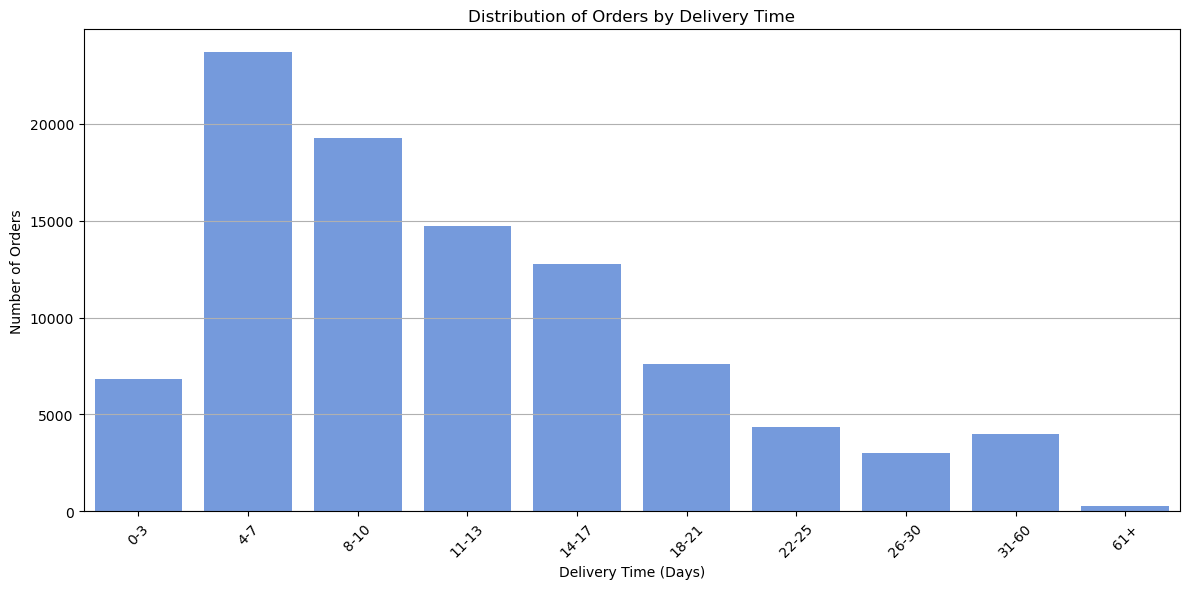

In [111]:
bins = [0, 3, 7, 10, 13, 17, 21, 25, 30, 60, 200]
labels = ['0-3', '4-7', '8-10', '11-13', '14-17', '18-21', '22-25', '26-30', '31-60', '61+']

delivery_days['delivery_bucket'] = pd.cut(
    delivery_days['delivery_days'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

bucketed = delivery_days.groupby('delivery_bucket', observed=True)['order_count'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='delivery_bucket', y='order_count', data=bucketed, color='cornflowerblue')
plt.title('Distribution of Orders by Delivery Time')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#### Conclusion:

#### The majority of orders are delivered in the interval between 4 and 17 days. Fast delivery in less than 4 days occurs more rarely. There also plenty of orders that were delivered in 18 - 60 days.

### What is the relationship between shipping cost and delivery distance?

#### First, I want to exclude orders where delivery cost is equal to zero.

In [112]:
zero_count = (order_items_df['freight_value'] == 0).sum()
print("Number of rows with delivery_cost = 0:", zero_count)

Number of rows with delivery_cost = 0: 383


#### Next, I need to get the necessary data from different tables into one dataframe

In [113]:
conn = sqlite3.connect("olist_ecommerce.db")
cursor = conn.cursor()

cursor.executescript("""CREATE TEMP TABLE geo_summary AS
SELECT 
    geolocation_zip_code_prefix,
    AVG(geolocation_lat) AS lat,
    AVG(geolocation_lng) AS lng
FROM geolocation
GROUP BY geolocation_zip_code_prefix;""")

In [114]:
query = """
    SELECT
    o.order_id,
    seller_id,
    o.customer_id,
    freight_value AS delivery_cost
FROM order_items
LEFT JOIN orders o ON order_items.order_id = o.order_id
WHERE freight_value > 0
ORDER BY delivery_cost DESC;
"""

delivery_cost = pd.read_sql(query, conn)
delivery_cost.head(3)

,order_id,seller_id,customer_id,delivery_cost
0,a77e1550db865202c56b19ddc6dc4d53,257e61d3251fb5efb9daadddbc2cf7ca,4eed76c1aafeceac4250e202ca9b1a5a,409.68
1,076d1555fb53a89b0ef4d529e527a0f6,6fa9202c10491e472dffd59a3e82b2a3,f08306b95370e8d5f0d97b71229284b6,375.28
2,3fde74c28a3d5d618c00f26d51baafa0,6fa9202c10491e472dffd59a3e82b2a3,f2c743697f9b2ff2902df23a16582d80,375.28


In [115]:
query = """
    SELECT
    customer_id,
    cg.lat AS customer_lat,
    cg.lng AS customer_lng
FROM customers
LEFT JOIN geo_summary cg ON customer_zip_code_prefix = cg.geolocation_zip_code_prefix
WHERE cg.geolocation_zip_code_prefix IS NOT NULL;
"""

customers_location = pd.read_sql(query, conn)

In [116]:
query = """
    SELECT
    seller_id,   
    sg.lat AS seller_lat,
    sg.lng AS seller_lng
FROM sellers
LEFT JOIN geo_summary sg ON seller_zip_code_prefix = sg.geolocation_zip_code_prefix
WHERE sg.lat IS NOT NULL;
"""

sellers_location = pd.read_sql(query, conn)

In [118]:
df = delivery_cost.merge(sellers_location, on='seller_id', how="inner")

In [119]:
df = df.merge(customers_location, on='customer_id', how="inner")

#### The final dataframe df contains customers and sellers location as well as the delivery cost for all the orders

In [120]:
df.head()

,order_id,seller_id,customer_id,delivery_cost,seller_lat,seller_lng,customer_lat,customer_lng
0,a77e1550db865202c56b19ddc6dc4d53,257e61d3251fb5efb9daadddbc2cf7ca,4eed76c1aafeceac4250e202ca9b1a5a,409.68,-23.540818,-51.451526,-9.014406,-42.691129
1,076d1555fb53a89b0ef4d529e527a0f6,6fa9202c10491e472dffd59a3e82b2a3,f08306b95370e8d5f0d97b71229284b6,375.28,-23.510381,-47.459520,-23.422728,-51.938295
2,3fde74c28a3d5d618c00f26d51baafa0,6fa9202c10491e472dffd59a3e82b2a3,f2c743697f9b2ff2902df23a16582d80,375.28,-23.510381,-47.459520,-27.442797,-48.498580
3,9f49bd16053df810384e793386312674,5c030029b5916fed0986310385ec9009,98ef9188ce9357bd77f60150a935c7fb,339.59,-27.584786,-48.580310,-22.736169,-45.585997
4,264a7e199467906c0727394df82d1a6a,17f51e7198701186712e53a39c564617,9913942a9bd26b840c4d19db0cbf6b89,338.30,-23.582595,-46.506968,-10.804117,-55.457814


#### To calculate geographical distances I will use the Haversine formula, which computes the distance between two points on the Earth based on their latitude and longitude.

In [121]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    # Convert degrees to radians
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    # Haversine formula
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # distance in kilometers

In [122]:
df['distance_km'] = haversine(
    df['customer_lat'],
    df['customer_lng'],
    df['seller_lat'],
    df['seller_lng']
)

#### After plotting the result I saw that data has outliers and I want to remove them

In [123]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to both columns
df_no_outliers = remove_outliers_iqr(df, 'delivery_cost')
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'distance_km')

In [124]:
correlation = df_no_outliers['delivery_cost'].corr(df['distance_km'])
print(f"Correlation between shipping cost and delivery distance: {correlation:.2f}")

Correlation between shipping cost and delivery distance: 0.53


#### Conclusion:

#### There is moderate positive correlation (0.53) between shipping cost and delivery distance.

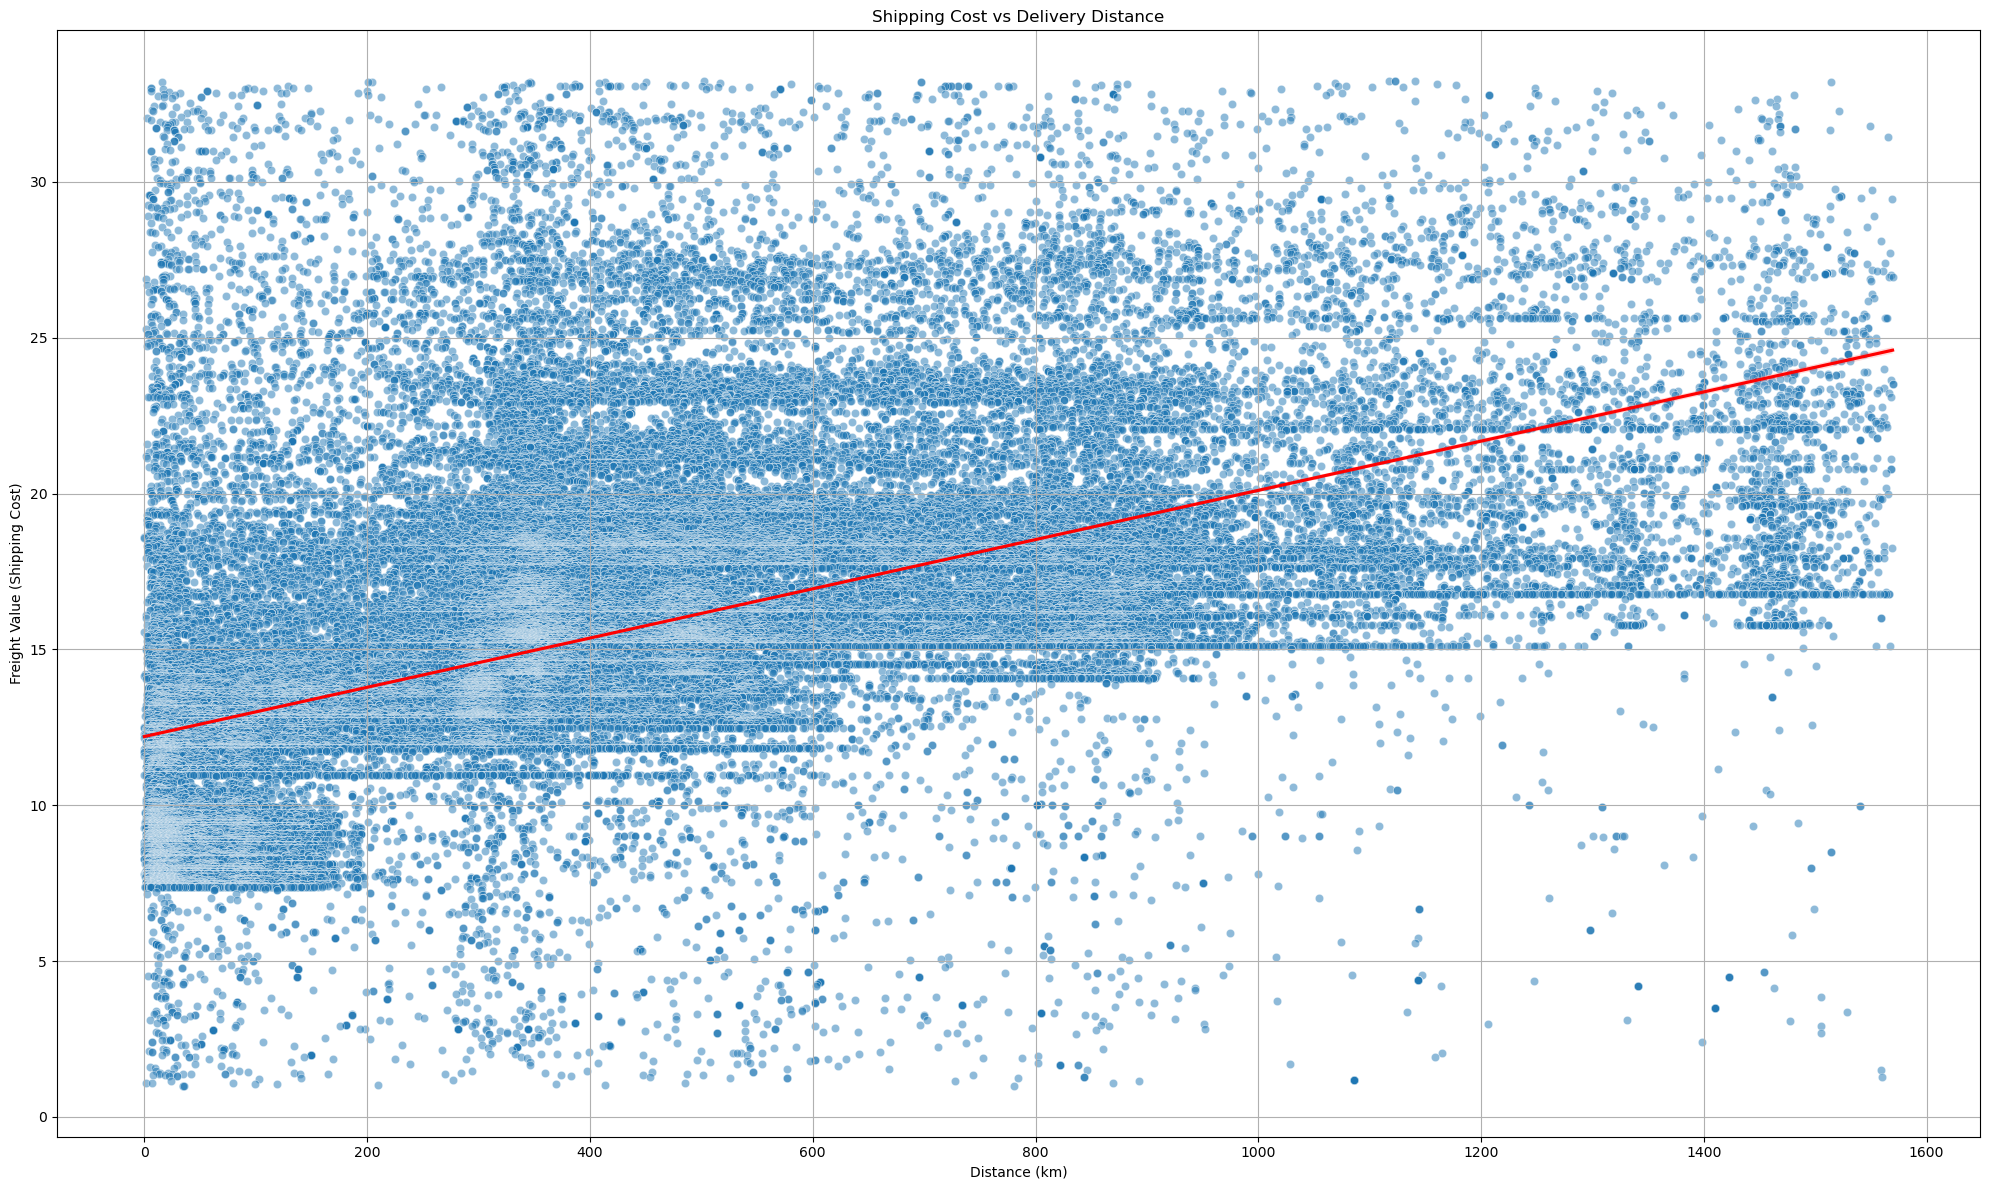

In [125]:
plt.figure(figsize=(20, 12))
sns.scatterplot(data=df_no_outliers, x='distance_km', y='delivery_cost', alpha=0.5)
sns.regplot(data=df_no_outliers, x='distance_km', y='delivery_cost', scatter=False, color='red')
plt.title('Shipping Cost vs Delivery Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Freight Value (Shipping Cost)')
plt.grid(True)
plt.tight_layout()
plt.show()